## Chapter 07

**(1)**&#8193;Consider the linear program of minimizing $x_1+x_2$ subject to the constraints $x_1+2 x_2 \geq 3,2 x_1+x_2 \geq 5$, and $x_2 \geq 0$. Graph the feasible region, and solve the program by hand or by our Julia code.  
$\textit{Solution}:$  

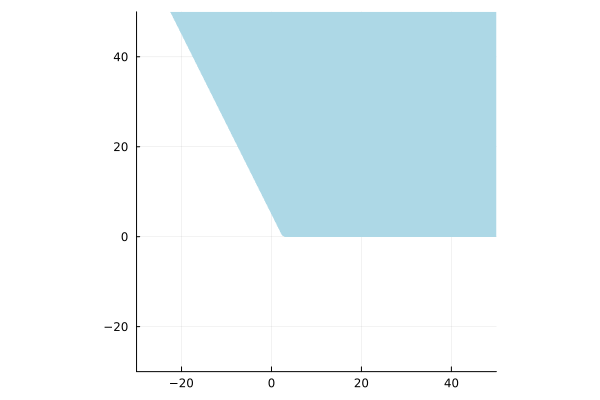

In [13]:
using Plots

f(x,y) = x + 2y
g(x,y) = 2x + y

θ(x,y) = (f(x,y) > 3) & (g(x,y) >5 ) & (y > 0) ? 1 : NaN

x = y = LinRange(-30,50,1000)
heatmap(x,y,θ, c=:lightblue, legend=false, ratio=1,
    xlims=extrema(x),ylims=extrema(y))

In [5]:
using LinearAlgebra, SparseArrays
function revised_simplex(A::AbstractMatrix{T}, b::Vector{T},
        c::Vector{T}, B::Vector{Int}, tol::T) where T <: Real
    (m, n) = size(A)
    N = setdiff(collect(1:n), B)
    ABinv = inv(convert(Matrix{T}, A[:, B]))
    xB = ABinv * b
    for iteration = 1:10*m
        mu = c[N]' - (c[B]' * ABinv) * A[:, N]
        k = argmin(mu')
        if mu[k] > -tol # test for convergence
            return (dot(c[B], xB), B, xB)
        else
            d = ABinv * A[:, N[k]] # possible update directions
            p = findall(d .> tol)
            if isempty(p)
                return (-Inf, nothing, nothing) # unbounded below
            end
            (t, i) = findmin(xB[p] ./ d[p])
            (B[p[i]], N[k]) = (N[k], B[p[i]]) # revise vertex set
            xB = xB -t * d
            xB[p[i]] = t
            v = ABinv[p[i], :] / d[p[i]] # Sherman-Morrison update
            d[p[i]] = d[p[i]] - one(T)
            ABinv = ABinv-d*v'
        end
    end
end

revised_simplex (generic function with 1 method)

In [2]:
function simplex_program(A::AbstractMatrix{T}, b::Vector{T},
        c::Vector{T}, tol::T) where T <: Real
    (m, n) = size(A)
    for i = 1:m
        if b[i] < zero(T)
            A[i, :] = - A[i, :]
            b[i] = - b[i]
        end
    end
    A1=[A I]
    c1 = [zeros(T, n); ones(T, m)]
    B = collect(n + 1:m + n)
    (cost, B, xB) = revised_simplex(A1, b, c1, B, tol) # first phase
    if cost > tol
        return ("unbounded", -Inf, B, xB)
    else
        (cost, B, xB) = revised_simplex(A, b, c, B, tol) # second phase
        if cost < -1e6
            return ("unbounded", -Inf, B, xB)
        else
            return ("solvable", cost, B, xB)
            end
        end
end

simplex_program (generic function with 1 method)

In [32]:
c = [1.0;-1; 1; 0; 0]; 
A=[1.0 -1 2 -1 0 ;2 -2 1 0 -1];
b = [ 3.0; 5];
A = sparse(A);
tol = 1e-5;
(status, cost, B, xB) = simplex_program(A, b, c, tol)

("solvable", 2.6666666666666665, [3, 1], [0.3333333333333334, 2.333333333333333])

**(2)**&#8193;Consider the linear program of maximizing $x_1+2 x_2+3 x_3+4 x_4+5$ subject to the constraints
$$
\begin{aligned}
4 x_1+3 x_2+2 x_3+x_4 & \leq 10 \\
x_1-x_3+2 x_4 &=2 \\
x_1+x_2+x_3+x_4 & \geq 1
\end{aligned}
$$
and $x_1 \geq 0, x_3 \geq 0, x_4 \geq 0$. Put this program into canonical form and solve.

$\textit{Solution}:$  
To maximize $x_1+2 x_2+3 x_3+4 x_4+5$, we first minimize $-x_1-2 x_2-3 x_3-4 x_4 = -x_1-2 (x_2^\prime-x_2^{\prime\prime})-3 x_3-4 x_4 $, and $x_1, x_2^\prime, x_2^{\prime\prime}, x_3, x_4 >0$
\begin{aligned}
\boldsymbol{c} &=\left[\begin{array}{lllll}
-1 & -2 & 2 & -3 & -4 & 0 &  0 
\end{array}\right]^{\mathrm{T}} \\
\boldsymbol{A} &=\left[\begin{array}{lllll}
4 & 3&-3 & 2 & 1 & 1 &  0 \\
1 & 0 &0& -1 & 2 & 0 &  0 \\
1 & 1&-1 & 1 & 1 & 0 &  -1 
\end{array}\right] \\
\boldsymbol{b} &=\left[\begin{array}{l}
10 \\
2\\
1
\end{array}\right]
\end{aligned}

In [31]:
c = [-1.0; -2; 2; -3; -4; 0; 0]; 
A=[4.0 3 -3 2 1 1 0 ;1 0 0 -1 2 0 0; 1 1 -1 1 1 0 -1 ];
b = [ 10.0; 2; 1];
A = sparse(A);
tol = 1e-5;
(status, cost, B, xB) = simplex_program(A, b, c, tol)

("unbounded", -Inf, nothing, nothing)

This linear program is unbounded.

**(3)**&#8193;Convert the problem of minimizing $\left|x_1+x_2+x_3\right|$ subject to $x_1-x_2=5$, $x_2-x_3=7$, and $x_1 \geq 0$, and $x_3 \geq 2$ into a linear program and solve.

$\textit{Solution}:$  
Set $t$ ,$t \geq |x_1+x_2+x_3|$   
Since $|x_1+x_2+x_3|$ is either $x_1+x_2+x_3$ or $-(x_1+x_2+x_3)$  
$t \geq x_1+x_2+x_3 $ and  $t \geq -(x_1+x_2+x_3) $  
Now, minimize $t$. So, our problem is  
$\min t$  
subject to
$x_1-x_2=5$  
$x_2-x_3=7$  
$t \geq x_1+x_2+x_3 $  
$t \geq -(x_1+x_2+x_3) $   
$x_1 \geq 0$, and $x_3 \geq 2$

In [44]:
c = [1.0; 0; 0; 0; 0; 0; 0; 0]; 
A=[1.0 -1 -1 1 -1 -1 0 0 ;1 1 1 -1 1 0 -1 0; 
    0 1 -1 1 0 0 0 0; 0 0 1 -1 -1 0 0 0; 0 0 0 0 1 0 0 -1 ];
b = [ 0.0; 0; 5; 7; 0];
A = sparse(A);
tol = 1e-5;
(status, cost, B, xB) = simplex_program(A, b, c, tol)

("solvable", 19.0, [1, 2, 7, 3, 5], [19.0, 12.0, 38.0, 7.0, 0.0])

**(6)**&#8193;A set $C$ is said to be convex if whenever $\boldsymbol{u}$ and $\boldsymbol{v}$ belong to $C$, then the entire line segment $[\boldsymbol{u}, \boldsymbol{v}]=\{t \boldsymbol{u}+(1-t) \boldsymbol{v}: t \in[0,1]\}$ belongs to $C$. Show that the feasible region of a linear program is convex. A set $C$ is said to be closed if whenever a sequence $\boldsymbol{x}_n$ from $C$ converges to a limit $\boldsymbol{x}$, then $\boldsymbol{x}$ also belongs to $C$. Show that the feasible region of a linear program is closed.

$\textit{Solution}:$  
Consider the feasible region $ S:=\left\{A x \leq b: x \in \mathbb{R}^n\right\}$  
$x, y \in S$ and an arbitrary convex combination $\alpha x+(1-\alpha) y$ with $\alpha \in(0,1)$  
$$
A(\alpha x+(1-\alpha) y)=\alpha A x+(1-\alpha) A y \leq \alpha b+(1-\alpha) b=b
$$
So S is convex.

## Chapter 08

**(3)**&#8193;Find the eigenvalues and eigenvectors of the rotation matrix
$$
\left(\begin{array}{cc}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta
\end{array}\right) \text {. }
$$
Note that the eigenvalues are complex conjugates.

$\textit{Solution}:$ 
set $A=\left[\begin{array}{cc}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta
\end{array}\right]$  

compute the characteristic polynomial $p(t)$
\begin{aligned}
p(t) &=\operatorname{det}(A-t I) \\
&=\left|\begin{array}{cc}
\cos \theta-t & -\sin \theta \\
\sin \theta & \cos \theta-t
\end{array}\right| \\
&=(\cos \theta-t)^2+\sin ^2 \theta \\
&=t^2-(2 \cos \theta) t+\cos ^2 \theta+\sin ^2 \theta \\
&=t^2-(2 \cos \theta) t+1
\end{aligned}

\begin{aligned}
t &=\frac{2 \cos \theta \pm \sqrt{(2 \cos \theta)^2-4}}{2} \\
&=\cos \theta \pm \sqrt{\cos ^2 \theta-1} \\
&=\cos \theta \pm \sqrt{-\sin ^2 \theta} \\
&=\cos \theta \pm i \sin \theta
\end{aligned}

$$
A-\lambda I=\left[\begin{array}{cc}
-i \sin \theta & -\sin \theta \\
\sin \theta & -i \sin \theta
\end{array}\right]
$$
If $\theta=0 $ or $\pi$, then $\sin \theta=0$ and we have
$$
A-\lambda I=\left[\begin{array}{ll}
0 & 0 \\
0 & 0
\end{array}\right]
$$
each nonzero vector of $\mathbb{R}^2$ is an eigenvector.

If $\lambda \neq 0, \lambda \neq \pi$, then $\sin \theta \neq 0$.
By row operations,
$$A-\lambda I=\left[\begin{array}{cc}
-i \sin \theta & -\sin \theta \\
\sin \theta & -i \sin \theta
\end{array}\right] \xrightarrow[\frac{t}{\sin \theta} R_2]{\frac{t}{\sin \theta} R_1} \left[\begin{array}{ll}
1 & -i \\
1 & -i
\end{array}\right] \xrightarrow{R_2-R_1}\left[\begin{array}{cc}
1 & -i \\
0 & 0
\end{array}\right]
$$
When $\theta=0$ or $\theta= \pi$, the eigenvalues are $1,-1$, respectively, and every nonzero vector of $\mathbb{R}^2$ is an eigenvector.  
If $\lambda \neq 0, \lambda \neq \pi$, then the eigenvector corresponding to the eigenvalue $\cos \theta+i \sin \theta$ is
$$
\left[\begin{array}{l}
i \\
1
\end{array}\right] t
$$
The eigenvector corresponding to the eigenvalue $\cos \theta-i \sin \theta$ is
$$
\left[\begin{array}{c}
-i \\
1
\end{array}\right] t
$$
where $t \neq 0$

**(4)**&#8193;Find the eigenvalues and eigenvectors of the reflection matrix
$$
\left(\begin{array}{cc}
\cos \theta & \sin \theta \\
\sin \theta & -\cos \theta
\end{array}\right)
$$

$\textit{Solution}:$ 
set $A=\left[\begin{array}{cc}
\cos \theta & \sin \theta \\
\sin \theta & -\cos \theta
\end{array}\right]$
\begin{aligned}
\operatorname{det}(A-\lambda I)&=\left|\begin{array}{cc}
\cos \theta-\lambda & \sin \theta \\
\sin \theta & -\cos \theta-\lambda
\end{array}\right| \\
&=\lambda^2 -{\cos \theta}^2-\sin ^2 \theta \\
&=\lambda^2-1\\
\lambda& =\pm1
\end{aligned}

Eigenvalues $= \pm 1$  
For $\lambda=1$, 
$$
\left(\begin{array}{cc}
\cos \theta-1 & \sin \theta \\
\sin \theta & -(\cos \theta+1)
\end{array}\right) v_1=0
$$
Take $R_2=-\frac{\sin \theta}{\cos \theta-1} R_1+R 2$,
$$
\left(\begin{array}{cc}
\cos \theta-1 & \sin \theta \\
0 & 0
\end{array}\right) v_1=0
$$
$$
v_1=\left(\begin{array}{l}
\cos \frac{\theta}{2} \\
\sin \frac{\theta}{2} 
\end{array}\right)
$$

For $\lambda=-1$, 
$$
\left(\begin{array}{cc}
\cos \theta+1 & \sin \theta \\
\sin \theta & -\cos \theta+1
\end{array}\right) v_2=0
$$
Take $R_2=-\frac{\sin \theta}{\cos \theta+1} R_1+R 2$,
$$
\left(\begin{array}{cc}
\cos \theta+1 & \sin \theta \\
0 & 0
\end{array}\right) v_2=0
$$
$$
v_2=\left(\begin{array}{l}
\sin \frac{\theta}{2} \\
-\cos \frac{\theta}{2} 
\end{array}\right)
$$

**(6)**&#8193;A matrix $A$ with real entries is said to be skew-symmetric if $A^*=-A$. Show that all eigenvalues of a skew-symmetric matrix are imaginary or 0 .

$\textit{Solution}:$  
$A +A^*=0$
let $v$ be an eigenvector,so $Av=\lambda v$ and $v \neq 0$
\begin{aligned}
v^*\left(A+A^*\right) v&=v^* A v+v^* A^* v\\
&=v^* \lambda v+(A v)^* v\\
&=\lambda v^* v+\bar{\lambda} v^* v\\
&=(\lambda+\bar{\lambda}) v^* v=0\\
&\lambda+\bar{\lambda} = 0\\
&-\lambda=\bar{\lambda}
\end{aligned}
$$\therefore \Re(\lambda)=0$$
$\lambda$ is either imaginary or 0.

**(7)**&#8193;Continuing the previous problem, suppose that $\boldsymbol{A}$ is skew-symmetric. Prove that $\boldsymbol{I}-\boldsymbol{A}$ is invertible and that $(\boldsymbol{I}-\boldsymbol{A})^{-1}(\boldsymbol{I}+\boldsymbol{A})$ is orthogonal. The latter matrix is called the Cayley transform of $\boldsymbol{A}$.

$\textit{Solution}:$  
By previous question, the eigenvalues of $A$ are imaginary or 0.  
The eigenvalues of $\boldsymbol{I}-\boldsymbol{A}$ are $1-\lambda$, where $\lambda$ is the eigenvalue of $A$.  
Since $\lambda$ is imaginary or 0, $1-\lambda$ cannot be 0.  
Thus, $\boldsymbol{I}-\boldsymbol{A}$ do not have eigenvalues equal to $0$.  
$det(\boldsymbol{I}-\boldsymbol{A})$ is the product of all eigenvalues of $\boldsymbol{I}-\boldsymbol{A}$, so $det(\boldsymbol{I}-\boldsymbol{A}) \neq 0$  
 $\boldsymbol{I}-\boldsymbol{A}$ is nonsingular and invertible. 

Set  $(\boldsymbol{I}-\boldsymbol{A})^{-1}(\boldsymbol{I}+\boldsymbol{A}) = B$   
To prove $B$ is orthogonal, we need to show  $B^{\mathrm{T}}B =I$ 
\begin{align*}
B^{\mathrm{T}} &=((I-A)^{-1}(I+A))^{\mathrm{T}} \\
&=(I+A)^{\mathrm{T}}((I-A)^{-1})^{\mathrm{T}} \\
&=(I+A)^{\mathrm{T}}((I-A)^{\mathrm{T}})^{-1} \\
&=(I^{\mathrm{T}}+A^{\mathrm{T}})(I^{\mathrm{T}}-A^{\mathrm{T}})^{-1} \\
&=(I+A^{\mathrm{T}})(I-A^{\mathrm{T}})^{-1}\\
&\overset{*}{=}(I-A)(I+A)^{-1}
\end{align*}
setp(*) holds because $\boldsymbol{A}$ is skew-symmetric, $A^{\mathrm{T}}=-A$

\begin{aligned}
B^{\mathrm{T}}B&= (I-A)(I+A)^{-1}(I-A)^{-1}(I+A)\\
&= (I-A)((I+A)(I-A))^{-1}(I+A)\\
&\overset{*}{=} (I-A)((I-A)(I+A))^{-1}(I+A)\\
&= (I-A)(I-A)^{-1}(I+A)^{-1}(I+A)\\
&= I \cdot I \\
&= I
\end{aligned}
setp(*) holds because 
$$
(I+A)(I-A)=(I+A) I-(I+A) A=I-A^2=(I-A) I+(I-A) A=(I-A)(I+A)
$$
So $B =(\boldsymbol{I}-\boldsymbol{A})^{-1}(\boldsymbol{I}+\boldsymbol{A}) $ is orthogonal.